In [1]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import sys
import tensorflow as tf
import keras
from keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, concatenate
from keras.models import Sequential, Model
from keras.layers import Layer
from random import randint
from keras.utils.np_utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


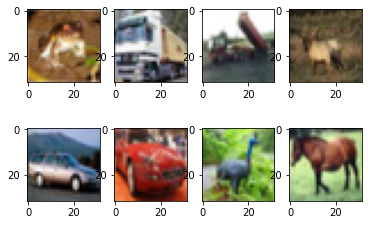

In [3]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [4]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [5]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [6]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [6]:
sys.path.insert(0, '../lib')

In [7]:
from split_1 import model_1_split

In [8]:
x_train_1, x_test_1, y_train_1, y_test_1 = model_1_split(n_img, n_noisy, imgs, noisy_labels, clean_labels, np, train_test_split)

In [9]:
# Normalizations
x_train_1=x_train_1/255.0
x_test_1=x_test_1/255.0

In [10]:
# Modify input shape
nsamples,nx,ny,nrgb=x_train_1.shape
x_train_2=x_train_1.reshape((nsamples,nx*ny*nrgb))
nsamples,nx,ny,nrgb=x_test_1.shape
x_test_2=x_test_1.reshape((nsamples,nx*ny*nrgb))

In [11]:
print(x_train_2.shape)
print(x_test_2.shape)

(45000, 3072)
(5000, 3072)


In [12]:
x_train0=x_train_2
x_test0=x_test_2
y_train0=[]
for i in range(len(y_train_1)):
    arr=[0.0]*10
    arr[int(y_train_1[i])]=1.0
    y_train0.append(np.array(arr))
y_train0=np.array(y_train0)
y_test0=[]
for i in range(len(y_test_1)):
    arr=[0]*10
    arr[int(y_test_1[i])]=1.0
    y_test0.append(np.array(arr))
y_test0=np.array(y_test0)

In [13]:
x_train0.shape

(45000, 3072)

In [15]:
def create_dense(layer_sizes):
    model=Sequential()
    model.add(Dense(layer_sizes[0],activation='sigmoid',input_shape=(3072,)))
    for s in layer_sizes[1:]:
        model.add(Dense(units=s,activation = 'sigmoid'))
    model.add(Dense(units=10,activation='softmax'))
    return model
def evaluate(model,xtrain,ytrain,xtest,ytest,batch_size=128,epochs=10,title="",plot=False):
    print(title)
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(xtrain,ytrain,batch_size=batch_size,epochs=epochs,validation_split=.1,verbose=False)
    loss,accuracy=model.evaluate(xtest,ytest,verbose=False)
    print(f'Test loss: {loss:.3}')
    print(f'Test accuracy: {accuracy:.3}')
    if plot is True:
        fig,ax=plt.subplots(1,2,figsize=(10,5))
        ax[0].plot(history.history["loss"])
        ax[0].plot(history.history["val_loss"])
        ax[0].title.set_text('Model Loss Function')
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss(Error)")
        ax[0].legend(['training', 'validation'], loc='best')
        
        ax[1].plot(history.history["accuracy"])
        ax[1].plot(history.history["val_accuracy"])
        ax[1].title.set_text('Accuracy function')
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")
        ax[1].legend(['training', 'validation'], loc='best')

# of nodes in the hidden layer = 128
Test loss: 2.19
Test accuracy: 0.231



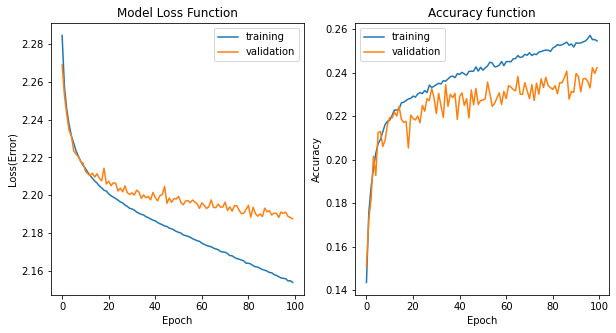

In [16]:
nodes=128
model = create_dense([nodes])
evaluate(model,x_train0,y_train0,x_test0,y_test0, epochs=100,title="# of nodes in the hidden layer = {}".format(nodes),plot=True)
print("=============================")
print()

In [17]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

# write your code here...

def model_I(image):
    img=image/255.0
    img=img.reshape(1,3072)
    return classes[np.argmax(model.predict(img))]
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

In [18]:
model.save("model_I.h5")

In [19]:
t,_,_,_=model_1_split(n_img, n_noisy, imgs, noisy_labels, clean_labels, np, train_test_split)
model_I(t[0])

1/1 [==============================] - 0s 68ms/step


'dog'

### 2.3. Model II

In [20]:
imgs_clean = imgs[:10000].reshape(-1,3072)

In [21]:
label_arr=random.sample(range(10000),3000)
label_arr.sort()
image_train_clean=[]
image_test=[]
y_train_clean=[]
y_test=[]
y_train_noisy=[]
y_test_noisy=[]
currind=0
for i in range(10000):
    if currind<3000 and label_arr[currind]==i:
        image_test.append(imgs_clean[i])
        y_test.append(clean_labels[i])
        y_test_noisy.append(noisy_labels[i])
        currind+=1
    else:
        image_train_clean.append(imgs_clean[i])
        y_train_clean.append(clean_labels[i])
        y_train_noisy.append(noisy_labels[i])
image_test=np.array(image_test)
image_train_clean=np.array(image_train_clean)
y_train_clean=np.array(y_train_clean)
y_test=np.array(y_test)
y_train_noisy=np.array(y_train_noisy)
y_test_noisy=np.array(y_test_noisy)

In [22]:
#Model 1 Accuracy
y_test_10=[]
for i in range(len(y_test)):
    arr=[0.0]*10
    arr[y_test[i]]=1.0
    y_test_10.append(np.array(arr))
y_test_10=np.array(y_test_10)
evaluate(model,x_train0,y_train0,image_test,y_test_10, epochs=100,title="# of nodes in the hidden layer = {}".format(nodes))

# of nodes in the hidden layer = 128
Test loss: 1.91
Test accuracy: 0.354


In [23]:
y_train_clean=to_categorical(y_train_clean, num_classes = 10)
y_test=to_categorical(y_test,num_classes=10)

In [24]:
y_train_noisy=to_categorical(y_train_noisy, num_classes = 10)
y_test_noisy=to_categorical(y_test_noisy,num_classes=10)

In [25]:
image_train_clean=image_train_clean.reshape(-1,32,32,3)
image_test=image_test.reshape(-1,32,32,3)

In [26]:
image_train_clean=image_train_clean/255.0
image_test=image_test/255.0

In [27]:
from tensorflow.keras.applications.vgg16 import VGG16

In [28]:
def create_vgg(X_train,y_train,EPOCHS=20,VS=0.1,BS=128,plot=False):
    sgd=optimizers.SGD(learning_rate=0.001, momentum=0.9)
    temp_model=VGG16(weights='imagenet',pooling="avg",include_top=False,input_shape=(32,32,3))
    temp_model.compile(optimizer=sgd,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
    base_out=temp_model.output
    top_fc1=BatchNormalization(name="hidden1")(base_out)
    top_fc2=Flatten(name="flatten")(top_fc1)
    top_fc3=Dense(128,activation="relu",name="hidden2")(top_fc2)
    top_fc4=Dropout(0.4)(top_fc3)
    top_fc5=Dense(10,activation="softmax",name="predictions")(top_fc4)
    model=tf.keras.Model(inputs=temp_model.input, outputs=top_fc5)
    model.compile(optimizer=sgd,
              loss="categorical_crossentropy",
              metrics=["accuracy"])
    history=model.fit(X_train, y_train,epochs=EPOCHS,verbose=1,validation_split=VS,batch_size=BS)
    if plot is True:
        fig,ax=plt.subplots(1,2,figsize=(10,5))
        ax[0].plot(history.history["loss"])
        ax[0].plot(history.history["val_loss"])
        ax[0].title.set_text('Model Loss Function')
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss(Error)")
        ax[0].legend(['training', 'validation'], loc='best')
        
        ax[1].plot(history.history["accuracy"])
        ax[1].plot(history.history["val_accuracy"])
        ax[1].title.set_text('Accuracy function')
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Accuracy")
        ax[1].legend(['training', 'validation'], loc='best')
    return model

Epoch 1/10
50/50 [==============================] - 117s 2s/step - loss: 1.9544 - accuracy: 0.3402 - val_loss: 2.6838 - val_accuracy: 0.1414
Epoch 2/10
50/50 [==============================] - 113s 2s/step - loss: 1.2456 - accuracy: 0.5824 - val_loss: 2.1086 - val_accuracy: 0.3043
Epoch 3/10
50/50 [==============================] - 115s 2s/step - loss: 1.0381 - accuracy: 0.6590 - val_loss: 1.3236 - val_accuracy: 0.5814
Epoch 4/10
50/50 [==============================] - 118s 2s/step - loss: 0.9029 - accuracy: 0.7013 - val_loss: 1.1371 - val_accuracy: 0.6557
Epoch 5/10
50/50 [==============================] - 116s 2s/step - loss: 0.7812 - accuracy: 0.7475 - val_loss: 0.9549 - val_accuracy: 0.7043
Epoch 6/10
50/50 [==============================] - 114s 2s/step - loss: 0.6859 - accuracy: 0.7794 - val_loss: 0.9245 - val_accuracy: 0.7029
Epoch 7/10
50/50 [==============================] - 115s 2s/step - loss: 0.6196 - accuracy: 0.7976 - val_loss: 0.9874 - val_accuracy: 0.6714
Epoch 8/10
50

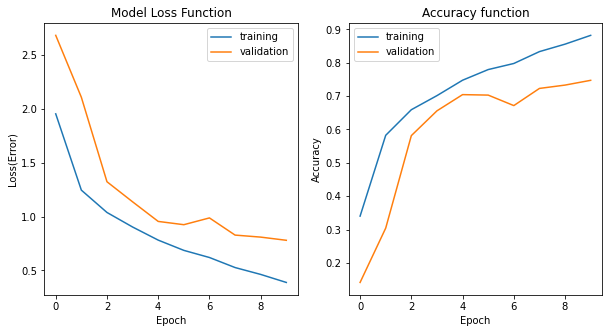

In [29]:
vgg_v1=create_vgg(image_train_clean,y_train_clean,EPOCHS=10,plot=True)

In [30]:
testing=vgg_v1.predict(image_test)
testing=np.array([np.argmax(i) for i in testing])
testing=to_categorical(testing,num_classes=10)

94/94 [==============================] - 6s 58ms/step


In [31]:
cnt=0
for i in range(len(testing)):
    for j in range(10):
        if testing[i][j]==y_test[i][j]==1:
            cnt+=1
print(cnt/len(testing))
#First iteration accuracy

0.7353333333333333


In [32]:
vgg_v1.save("simple_vgg.h5")

Label Cleaning

In [33]:
# define two sets of inputs
inputA = tf.keras.Input(shape=(32,32,3))
inputB = tf.keras.Input(shape=(10,))
# the first branch operates on the first input
sgd=optimizers.SGD(learning_rate=0.001, momentum=0.9)
temp_model=VGG16(weights='imagenet',pooling="avg",include_top=False,input_shape=(32,32,3))
temp_model.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=["accuracy"])
base_out=temp_model.output
x = Dense(128, activation="relu")(base_out)
# the second branch opreates on the second input
y = Dense(128, activation="relu")(inputB)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = concatenate([x, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(128, activation="relu")(combined)
z = Dropout(0.4)(z)
z = Dense(10, activation="softmax")(z)
# our model will accept the inputs of the two branches and
# then output a single value
label_clearing_model = Model(inputs=[temp_model.input, y.input], outputs=z)

Epoch 1/20
50/50 [==============================] - 116s 2s/step - loss: 2.2037 - accuracy: 0.1751 - val_loss: 1.8493 - val_accuracy: 0.3971
Epoch 2/20
50/50 [==============================] - 119s 2s/step - loss: 1.6591 - accuracy: 0.4108 - val_loss: 1.2283 - val_accuracy: 0.5629
Epoch 3/20
50/50 [==============================] - 116s 2s/step - loss: 1.3075 - accuracy: 0.5433 - val_loss: 1.1362 - val_accuracy: 0.5943
Epoch 4/20
50/50 [==============================] - 116s 2s/step - loss: 1.1203 - accuracy: 0.6108 - val_loss: 0.9683 - val_accuracy: 0.6700
Epoch 5/20
50/50 [==============================] - 124s 2s/step - loss: 0.9541 - accuracy: 0.6737 - val_loss: 0.8779 - val_accuracy: 0.6943
Epoch 6/20
50/50 [==============================] - 118s 2s/step - loss: 0.8500 - accuracy: 0.7141 - val_loss: 0.7874 - val_accuracy: 0.7357
Epoch 7/20
50/50 [==============================] - 117s 2s/step - loss: 0.8150 - accuracy: 0.7284 - val_loss: 0.8113 - val_accuracy: 0.7200
Epoch 8/20
50

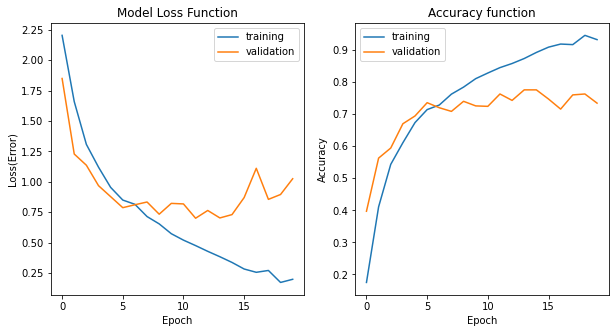

In [34]:
label_clearing_model.compile(optimizer=sgd,loss="categorical_crossentropy",metrics=["accuracy"])
history=label_clearing_model.fit([image_train_clean,y_train_noisy],y_train_clean,
                                 epochs=20,
                                 verbose=1,
                                 validation_split=0.1,
                                 batch_size=128)
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot(history.history["loss"])
ax[0].plot(history.history["val_loss"])
ax[0].title.set_text('Model Loss Function')
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss(Error)")
ax[0].legend(['training', 'validation'], loc='best')
ax[1].plot(history.history["accuracy"])
ax[1].plot(history.history["val_accuracy"])
ax[1].title.set_text('Accuracy function')
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend(['training', 'validation'], loc='best')

In [35]:
label_clearing_model.save("label_clearing_model.h5")

In [36]:
noisy_labels_10=to_categorical(noisy_labels[10000:],num_classes=10)

In [37]:
prednoisy=label_clearing_model.predict([imgs[10000:],noisy_labels_10])

1250/1250 [==============================] - 71s 57ms/step


In [38]:
prednoisy=np.array([np.argmax(i) for i in prednoisy])
prednoisy=to_categorical(prednoisy,num_classes=10)

In [39]:
y_train_1=np.concatenate((y_train_clean,prednoisy))

In [40]:
t=imgs[10000:50000]/255

In [41]:
x_train_1=np.concatenate((image_train_clean,t))

In [42]:
vgg_v2=create_vgg(x_train_1,y_train_1,EPOCHS=10)

Epoch 1/10
331/331 [==============================] - 781s 2s/step - loss: 1.2319 - accuracy: 0.5919 - val_loss: 0.8464 - val_accuracy: 0.7106
Epoch 2/10
331/331 [==============================] - 783s 2s/step - loss: 0.7281 - accuracy: 0.7515 - val_loss: 0.6040 - val_accuracy: 0.7849
Epoch 3/10
331/331 [==============================] - 777s 2s/step - loss: 0.5931 - accuracy: 0.7958 - val_loss: 0.4931 - val_accuracy: 0.8177
Epoch 4/10
331/331 [==============================] - 780s 2s/step - loss: 0.5119 - accuracy: 0.8243 - val_loss: 0.5584 - val_accuracy: 0.8077
Epoch 5/10
331/331 [==============================] - 797s 2s/step - loss: 0.4457 - accuracy: 0.8460 - val_loss: 0.4695 - val_accuracy: 0.8260
Epoch 6/10
331/331 [==============================] - 805s 2s/step - loss: 0.3897 - accuracy: 0.8678 - val_loss: 0.5244 - val_accuracy: 0.8072
Epoch 7/10
331/331 [==============================] - 804s 2s/step - loss: 0.3446 - accuracy: 0.8825 - val_loss: 0.4752 - val_accuracy: 0.8221

In [43]:
testingv2=vgg_v2.predict(image_test)
testingv2=np.array([np.argmax(i) for i in testingv2])
testingv2=to_categorical(testingv2,num_classes=10)

94/94 [==============================] - 5s 56ms/step


In [44]:
cnt=0
for i in range(len(testingv2)):
    for j in range(10):
        if testingv2[i][j]==y_test[i][j]==1:
            cnt+=1
print(cnt/len(testing))
#Second Iteration accuracy ??????

0.6606666666666666


In [45]:
vgg_v2.save("final_vgg.h5")

In [46]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# write your code here...

def model_II(image):
    
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # write your code here...

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [47]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [48]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

OSError: ../data/test_labels.csv not found.

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.